In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, Flatten, Reshape

from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1000)

In [3]:
num_classes = 5
(x_train, _), (_, _) = cifar10.load_data()
print(x_train.shape)

170498071/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)


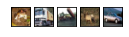

In [10]:
n = 5
plt.figure(figsize=(2,2))
for i in range(n):
    sublpot = plt.subplot(2,n,i+1)
    plt.imshow(x_train[i])
    sublpot.get_xaxis().set_visible(False)
    sublpot.get_yaxis().set_visible(False)
plt.show()

In [11]:
optim = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [12]:
generator = Sequential()
n_nodes = 256 * 4 * 4
generator.add(Dense(n_nodes, input_dim=100))
generator.add(LeakyReLU(alpha=0.2))
generator.add(Reshape((4, 4, 256)))
generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
generator.add(LeakyReLU(alpha=0.2))
generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
generator.add(LeakyReLU(alpha=0.2))
generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
generator.add(LeakyReLU(alpha=0.2))
generator.add(Conv2D(3, (3,3), activation='tanh', padding='same'))

In [13]:
disc = Sequential()
disc.add(Conv2D(64, (3,3), padding='same', input_shape=(32,32,3)))
disc.add(LeakyReLU(alpha=0.2))
disc.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
disc.add(LeakyReLU(alpha=0.2))
disc.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
disc.add(LeakyReLU(alpha=0.2))
disc.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
disc.add(LeakyReLU(alpha=0.2))
disc.add(Flatten())
disc.add(Dropout(0.4))
disc.add(Dense(1, activation='sigmoid'))
disc.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])

In [14]:
disc.trainable=False
gan = Sequential()
gan.add(generator)
gan.add(disc)
gan.compile(loss='binary_crossentropy', optimizer=optim)


In [17]:
discrim_losses =  []
num_batches = int(x_train.shape[0]/128)
for ep in range(2):
    for i in range(num_batches):
        noise = np.random.normal(0, 1, size=[128, 100])
        image_batch = x_train[np.random.randint(0, x_train.shape[0], size=128)]

        generated_images = generator.predict(noise)

        X = np.concatenate([image_batch, generated_images])
        y_dis = np.zeros(2*128)
        y_dis[:128] = 0.9  
        disc.trainable = True
        d_loss, _ = disc.train_on_batch(X, y_dis)
        discrim_losses.append(d_loss)

        noise = np.random.normal(0, 1, size=[128, 100])
        y_gen = np.ones(128)
        disc.trainable = False
        gan.train_on_batch(noise, y_gen)
    if ep % 10 == 0:
        print('epoch: ', ep)
        num_of_images = 5
        noise = np.random.normal(0, 1, size=[num_of_images, 100])
        generated_images=generator.predict(noise)
        generated_images = (generated_images + 1) / 2.0
        plt.figure(figsize=(2, 2))
        for i in range(num_of_images):
            plt.subplot(1, 10, i+1)
            plt.imshow(generated_images[i])
            plt.axis('off')
            plt.tight_layout()
        plt.show()

4/4 [==============================] - 1s 284ms/step
epoch:  0
1/1 [==============================] - 0s 181ms/step


4/4 [==============================] - 1s 283ms/step


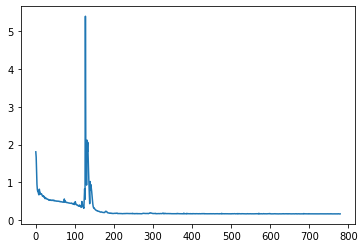

In [18]:
plt.plot(discrim_losses)